In [146]:
# pip install scikit-optimize==0.7.4
#!pip install scikit-learn==0.22

## Data

In [170]:
import pandas as pd
import numpy  as np
import pickle
import os 
import json

from utils import create_directory

# XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
# Itertools
import itertools

# LightGBM
import lightgbm as lgb

# Bayesian Optimizer
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, auc, roc_curve, matthews_corrcoef, roc_auc_score, classification_report, mean_squared_error, confusion_matrix, f1_score, precision_recall_curve, r2_score
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold


#https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

In [171]:
full_data = pd.read_csv(r"data/prepared_data_for_modeling.csv")
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23485 entries, 0 to 23484
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   datetime                    23485 non-null  object 
 1   campaign_id                 23485 non-null  int64  
 2   spend                       23485 non-null  float64
 3   impressions                 23485 non-null  float64
 4   clicks                      23485 non-null  float64
 5   purchase                    23485 non-null  float64
 6   hour                        23485 non-null  int64  
 7   unique_ids                  23485 non-null  object 
 8   first_24_hour               23485 non-null  bool   
 9   test_set                    23485 non-null  bool   
 10  ctr                         23485 non-null  float64
 11  conversion_rate             23485 non-null  float64
 12  custom_conversion_rate      23485 non-null  float64
 13  good_performance            234

Get Useful features

In [172]:
def get_feature_list_from_text(path:str, extension:str='pickle')->list:
    
    try:
        if extension=='pickle':
            with open(path, "rb") as opened_file:
                print('Successfully returned list from: ', path)
                return pickle.load(opened_file)
    except Exception as error:
        raise Exception('Caught this error: ' + repr(error))

In [173]:
sample_features = get_feature_list_from_text(r"data/feature_lists_for_modeling.txt")
sample_features

Successfully returned list from:  data/feature_lists_for_modeling.txt


['campaign_id',
 'hour',
 'dayofweek',
 'spend',
 'purchase',
 'impressions',
 'conversion_rate',
 'custom_conversion_rate',
 'good_performance',
 'next_hour_good_performance']

In [192]:
sample_features = ['campaign_id', 'hour', 'dayofweek','purchase', 
                   'impressions',
                   'good_performance',
                   'next_hour_good_performance']

Specify target variable

In [193]:
target = 'next_hour_good_performance'
sample_features.remove(target)

Get Train/Test Split

In [194]:
training_data = full_data[full_data['first_24_hour']][sample_features+[target]]
X_train = training_data[sample_features]
y_train = training_data[target]

test_data = full_data[full_data['test_set']][sample_features+[target]]
X_test = test_data[sample_features]
y_test = test_data[target]

del training_data, test_data

Take full data for optimization

In [195]:
X = full_data[full_data['first_24_hour']][sample_features]
y = full_data[full_data['first_24_hour']][target]

# Modeling

#### Outline
   
- **Hyperparameter tuning and CV using Bayesian Optimizer** 
    - Scikit-optimize provides a drop-in replacement for GridSearchCV, which utilizes Bayesian Optimization where a predictive model referred to as "surrogate" is used to model the search space and utilized to arrive at good parameter values combination as soon as possible.<br>

- **Train and evaluate Models with best params found**
    - XGBOOST
    - LightGBM
    
- **Save and Load models**

In [177]:
# Define a function to print the status during bayesian hyperparameter search

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
def save_tuning_result(model_name:str, info:dict, path:str)->None:

    try:
        directory = os.path.join(path, model_name)
        create_directory(directory)
        file = open(f"{directory}{os.sep}best_params.json", "w")
        json.dump(info, file)
        file.close()
        print('Successfully saved results in', directory)
    except Exception as error:
        raise Exception('Caught this error: ' + repr(error))
        
def get_tuning_result(model_name:str, path:str)->dict:
    
    try:
        directory = os.path.join(path, model_name)
        file = open(f"{directory}{os.sep}best_params.json", "r") 
        return file.read()
    except Exception as error:
        raise Exception('Caught this error: ' + repr(error))

In [178]:
# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def to_labels(pos_probs, threshold):
# apply threshold to positive probabilities to create labels

    return (pos_probs >= threshold).astype('int')

    
def get_best_threshold(pos_probs:list,)->float:
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)

    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(pos_probs, t), average='macro') for t in thresholds]


    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, Macro F-Score=%.5f' % (thresholds[ix], scores[ix]))
    
    return thresholds[ix]

# Define a function which will be used to get the important parameters like AUC, Classification report
def print_report(test_set, predictions, labels, threshold:int = None):
    
    if not threshold:
        threshold = get_best_threshold(predictions)
        
    predictions = predictions>threshold
    
    cr = classification_report(test_set, predictions, target_names=labels)
    cm = confusion_matrix(test_set,  predictions)
    mcc = matthews_corrcoef(test_set,  predictions)
    plot_confusion_matrix(confusion_matrix(test_set, predictions),labels)
    
    #plot the curve
    fpr, tpr, threshold = roc_curve(test_set,predictions)
    auc = roc_auc_score(test_set, predictions)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='Model - AUC = %0.3f'% auc)
    ax.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--', label='Chance')
    ax.legend()
    ax.set_xlim([-0.1,1.0])
    ax.set_ylim([-0.1,1.01])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    plt.show()
    
    print(cr)
    #print('Macro F1 score is:', f1_score(test_set,predictions, average='macro'))
    print('Matthews correlation coefficient: ', mcc)


    
def save_model(model:object, path:str, model_name:str, extension:str='pickle'):

    try:
        if extension=='pickle':
            create_directory(path)
            model_name += ".pickle.dat"
            directory = os.path.join(path, model_name)

            pickle.dump(model, open(directory, "wb"))
            print('{} saved in : {}'.format(model_name, path))
        else:
            raise NotImplementedError
    except Exception as error:
        raise Exception('Caught this error: ' + repr(error))
        
def get_model(path:str, model_name:str, extension:str='pickle'):
    
    try: 
        if extension=='pickle':
            directory = os.path.join(path, model_name)
            print('{} found at {}.'.format(model_name, directory))
            return pickle.load(open(directory+".pickle.dat", "rb"))
    except Exception as error:
        raise Exception('Caught this error: ' + repr(error))

In [179]:
def get_tuned_result(model_name:str, path:str)->dict:
    
    directory = os.path.join(path, model_name)
    file = open(f"{directory}{os.sep}best_params.json", "r") 
    
    return json.loads(file.read())

def get_prediction(model:object, data:pd.core.frame.DataFrame):
    predict_proba = model.predict_proba(data)[:, 1]
    return predict_proba

### XGBoost

#### Hpo

In [180]:
# # SETTINGS - CHANGE THESE TO GET SOMETHING MEANINGFUL
# ITERATIONS = 50

# # Classifier
# bayes_cv_tuner = BayesSearchCV(
#     estimator = XGBClassifier(
#         n_jobs = 1,
#         objective = 'binary:logistic',
#         eval_metric = 'auc',
#         silent=1,
#         tree_method='approx'
#     ),
#     search_spaces = {
#         'learning_rate': (0.01, 1.0, 'log-uniform'),
#         'min_child_weight': (0, 10),
#         'max_depth': (1, 50),
#         'max_delta_step': (0, 20),
#         'subsample': (0.01, 1.0, 'uniform'),
#         'colsample_bytree': (0.01, 1.0, 'uniform'),
#         'colsample_bylevel': (0.01, 1.0, 'uniform'),
#         'reg_lambda': (1e-9, 1000),
#         'reg_alpha': (1e-9, 1.0, 'log-uniform'),
#         'gamma': (1e-9, 0.5, 'log-uniform'),
#         'n_estimators': (50, 100),
#         'scale_pos_weight': (1, 50, 'log-uniform')
#     },    
#     scoring = 'roc_auc',
#     cv = StratifiedKFold(n_splits=3,
#                          shuffle=True,
#                          random_state=42),
#     n_jobs = 3,
#     n_iter = ITERATIONS,   
#     verbose = 0,
#     refit = True,
#     random_state = 42
# )

In [181]:
ITERATIONS = 100

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (5, 500),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'n_estimators': (50, 500),
        'scale_pos_weight': (1, 50, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(n_splits=3,
                         shuffle=True,
                         random_state=42),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

Start finding parameters and save result

In [123]:
#xgb_tuning_result = bayes_cv_tuner.fit(X, y, callback=status_print)
##save_tuning_result('XGB', xgb_tuning_result.best_params_, 'HPO')

Load best params found

In [167]:
best_params = get_tuned_result('XGB', 'HPO')
#best_params = xgb_tuning_result.best_params_
best_params

{'colsample_bylevel': 0.8015579071911014,
 'colsample_bytree': 0.44364889457651413,
 'gamma': 3.811128976537413e-05,
 'learning_rate': 0.2700390206185342,
 'max_delta_step': 18,
 'max_depth': 36,
 'min_child_weight': 4,
 'n_estimators': 83,
 'reg_alpha': 1.5057560255472018e-06,
 'reg_lambda': 659.4262286994368,
 'scale_pos_weight': 26,
 'subsample': 0.8835665823899177}

##### Train Model

In [182]:
#50 Iteration
xgb_model = XGBClassifier(colsample_bylevel= best_params['colsample_bylevel'],
                          colsample_bytree= best_params['colsample_bytree'], 
                          gamma= best_params['gamma'],
                          learning_rate= best_params['learning_rate'],
                          max_delta_step= best_params['max_delta_step'], 
                          max_depth= best_params['max_depth'],
                          min_child_weight= best_params['min_child_weight'],
                          n_estimators= best_params['n_estimators'],
                          reg_alpha= best_params['reg_alpha'], 
                          reg_lambda= best_params['reg_lambda'],
                          scale_pos_weight= best_params['scale_pos_weight'],
                          subsample= best_params['subsample'])

xgb_model.fit(X_train, y_train)
print('\n\nModel trained successfully!')

F:\miniconda3\envs\lfi\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:10:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Model trained successfully!


#### Evaluate Model

On Test Set

F:\miniconda3\envs\lfi\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Threshold=0.840, Macro F-Score=0.66441


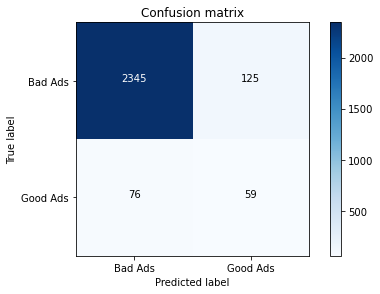

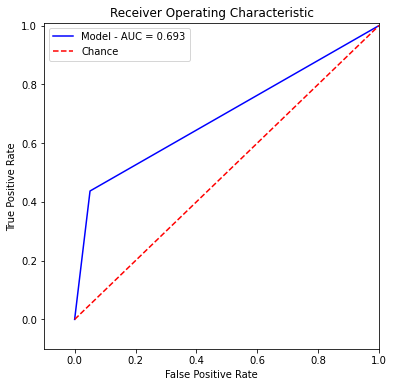

              precision    recall  f1-score   support

     Bad Ads       0.97      0.95      0.96      2470
    Good Ads       0.32      0.44      0.37       135

    accuracy                           0.92      2605
   macro avg       0.64      0.69      0.66      2605
weighted avg       0.94      0.92      0.93      2605

Matthews correlation coefficient:  0.33433327934652285


In [126]:
preidiction = get_prediction(xgb_model, X_test)

labels = ['Bad Ads', 'Good Ads']
print_report(y_test, preidiction, labels)

On Training set

F:\miniconda3\envs\lfi\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


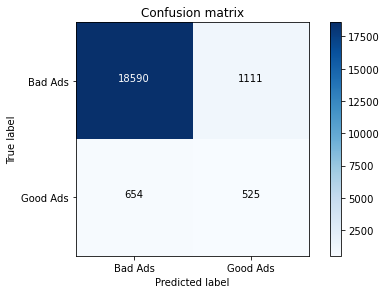

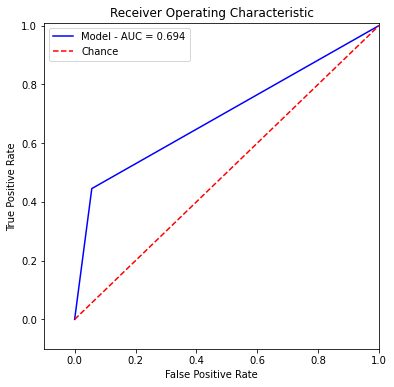

              precision    recall  f1-score   support

     Bad Ads       0.97      0.94      0.95     19701
    Good Ads       0.32      0.45      0.37      1179

    accuracy                           0.92     20880
   macro avg       0.64      0.69      0.66     20880
weighted avg       0.93      0.92      0.92     20880

Matthews correlation coefficient:  0.3340405180966698


In [127]:
preidiction = get_prediction(xgb_model, X_train)
print_report(y_train, preidiction, labels, threshold=0.840)

#### Save Model

In [128]:
# save model to file
# path = 'model'
# model_name = 'xgb_model'

## save_model(xgb_model, path, model_name)

xgb_model.pickle.dat saved in : model


#### Load Model

In [82]:
# path = 'model'
# model_name = 'xgb_model'

# # load model from file
# loaded_model = get_model(path, model_name)
# pred_proba = get_prediction(loaded_model, X_test)

# labels = ['Bad Ads', 'Good Ads']
# print_report(y_test, pred_proba, labels)

## b. LightGBM

#### HPO

In [186]:
ITERATIONS = 100

bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        n_jobs = 1,
        objective = 'binary',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    
    search_spaces = {
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'learning_rate': (0.001, 1.0, 'log-uniform'),
        'max_depth': (1, 500),
        'max_bin':(50,5000),
        'n_estimators': (50, 100),
        'reg_lambda': (1e-9, 1000.0, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1, 100, 'log-uniform'),
        'subsample': (0.01, 1.0, 'uniform'),
        "boosting_type": ["gbdt", "dart"],
        "num_leaves": (100, 2000),
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

Start finding parameters and save result

In [187]:
#light_gbm_tuned = bayes_cv_tuner.fit(X, y, callback=status_print)
##save_tuning_result('LightGBM', light_gbm_tuned.best_params_, 'HPO')

Load best params found

In [130]:
best_params = get_tuned_result('LightGBM', 'HPO')
#best_params = light_gbm_tuned.best_params_
best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.4194735998017874,
 'learning_rate': 0.12136702654025933,
 'max_bin': 4761,
 'max_depth': 15,
 'n_estimators': 60,
 'num_leaves': 2000,
 'reg_alpha': 1.0,
 'reg_lambda': 1000.0,
 'scale_pos_weight': 32,
 'subsample': 0.7029212166466253}

#### Train Model

In [196]:
lgb_model  = lgb.LGBMClassifier(colsample_bytree = best_params['colsample_bytree'], 
                               learning_rate = best_params['learning_rate'], 
                               max_depth = best_params['max_depth'], 
                               n_estimators = best_params['n_estimators'], 
                               reg_alpha = best_params['reg_alpha'], 
                               reg_lambda = best_params['reg_lambda'],
                               scale_pos_weight  = best_params['scale_pos_weight'], 
                               boosting_type = best_params['boosting_type'], 
                               subsample = best_params['subsample'], 
                               num_leaves = best_params['num_leaves'])

lgb_model.fit(X_train, y_train)
print('\n\nModel trained successfully!')



Model trained successfully!


#### Evaluate Model

On Test Set

Threshold=0.831, Macro F-Score=0.64365


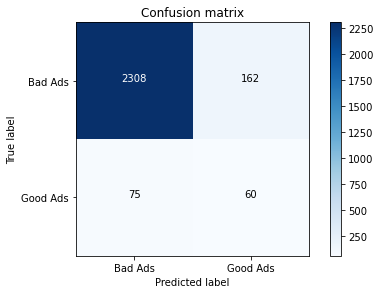

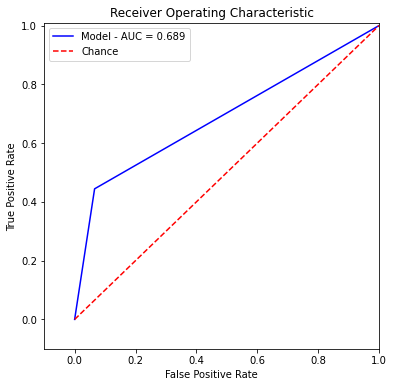

              precision    recall  f1-score   support

     Bad Ads       0.97      0.93      0.95      2470
    Good Ads       0.27      0.44      0.34       135

    accuracy                           0.91      2605
   macro avg       0.62      0.69      0.64      2605
weighted avg       0.93      0.91      0.92      2605

Matthews correlation coefficient:  0.3007825430415892


In [131]:
preidiction = get_prediction(lgb_model, X_test)

labels = ['Bad Ads', 'Good Ads']
print_report(y_test, preidiction, labels)

On Training Set

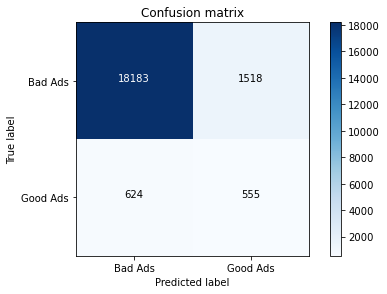

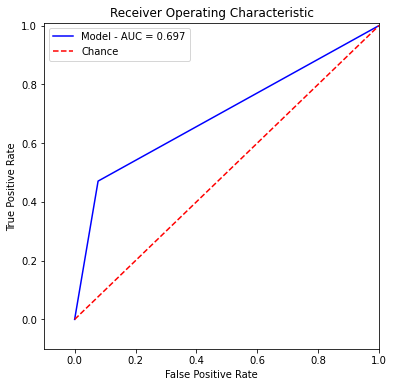

              precision    recall  f1-score   support

     Bad Ads       0.97      0.92      0.94     19701
    Good Ads       0.27      0.47      0.34      1179

    accuracy                           0.90     20880
   macro avg       0.62      0.70      0.64     20880
weighted avg       0.93      0.90      0.91     20880

Matthews correlation coefficient:  0.3038726278319284


In [132]:
preidiction = get_prediction(lgb_model, X_train)
print_report(y_train, preidiction, labels, threshold = 0.831)

#### Save Model

In [133]:
# # save model to file
# path = 'model'
# model_name = 'lightGBM_model'

# save_model(lgb_model, path, model_name)

lightGBM_model.pickle.dat saved in : model


#### Load Model

lightGBM_model found at model\lightGBM_model.


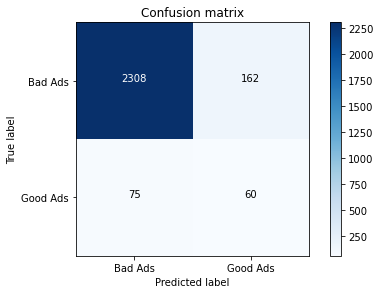

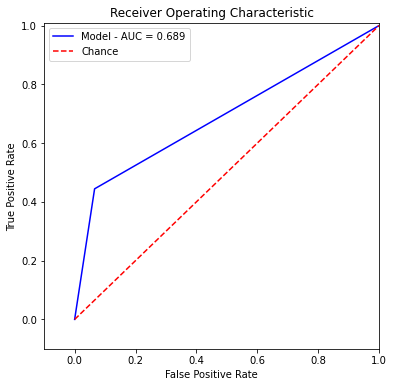

              precision    recall  f1-score   support

     Bad Ads       0.97      0.93      0.95      2470
    Good Ads       0.27      0.44      0.34       135

    accuracy                           0.91      2605
   macro avg       0.62      0.69      0.64      2605
weighted avg       0.93      0.91      0.92      2605

Matthews correlation coefficient:  0.3007825430415892


In [135]:
# path = 'model'
# model_name = 'lightGBM_model'

# # load model from file
# loaded_model = get_model(path, model_name)
# pred_proba = get_prediction(loaded_model, X_test)

# labels = ['Bad Ads', 'Good Ads']
# print_report(y_test, pred_proba, labels, threshold = 0.831)